##### PyMC3 Examples

# GLM Poisson Regression

#### A minimal reproducable example of poisson regression to predict counts using dummy data.

This Notebook is basically an excuse to demo poisson regression using PyMC3, both manually and using the `glm` library to demo interactions using the `patsy` library. We will create some dummy data, poisson distributed according to a linear model, and try to recover the coefficients of that linear model through inference.

For more statistical detail see:

+ Basic info on [Wikipedia](https://en.wikipedia.org/wiki/Poisson_regression)
+ GLMs: Poisson regression, exposure, and overdispersion in Chapter 6.2 of [ARM, Gelmann & Hill 2006](http://www.stat.columbia.edu/%7Egelman/arm/)
+ This worked example from ARM 6.2 by [Clay Ford](http://www.clayford.net/statistics/poisson-regression-ch-6-of-gelman-and-hill/)

This very basic model is insipired by [a project by Ian Osvald](http://ianozsvald.com/2016/05/07/statistically-solving-sneezes-and-sniffles-a-work-in-progress-report-at-pydatalondon-2016/), which is concerend with understanding the various effects of external environmental factors upon the allergic sneezing of a test subject.


#### Contents

+ [Setup](#Setup)
    + [Local Functions](#Local-Functions)
    + [Generate Data](#Generate-Data)


+ [Poisson Regression](#Poisson-Regression)
    + [Create Design Matrices](#Create-Design-Matrices)
    + [Create Model](#Create-Model)
    + [Sample Model](#Sample-Model)
    + [View Diagnostics and Outputs](#View-Diagnostics-and-Outputs)



#### Package Requirements (shown as a conda-env YAML):
```
$> less conda_env_pymc3_examples.yml

name: pymc3_examples
channels:
  - defaults
dependencies:
    - python=3.5
    - jupyter
    - ipywidgets
    - numpy
    - scipy
    - matplotlib
    - pandas
    - pytables
    - scikit-learn
    - statsmodels
    - seaborn
    - patsy
    - requests
    - pip
    - pip:
        - regex        

$> conda env create --file conda_env_pymc3_examples.yml
$> source activate pymc3_examples
$> pip install --process-dependency-links git+https://github.com/pymc-devs/pymc3

```


# Setup

In [1]:
## Interactive magics
%matplotlib inline
%qtconsole --colors=linux

In [2]:
import sys
import warnings
warnings.filterwarnings('ignore')

import regex as re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import patsy as pt
from scipy import optimize

# pymc3 libraries
import pymc3 as pm
import theano as thno
import theano.tensor as T 
# import pystan

# get watermark
%install_ext https://raw.githubusercontent.com/rasbt/watermark/master/watermark.py

sns.set(style="darkgrid", palette="muted")
pd.set_option('display.mpl_style', 'default')
plt.rcParams['figure.figsize'] = 14, 6
np.random.seed(0)

Installed watermark.py. To use it, type:
  %load_ext watermark


##### What versions are we running?

In [3]:
%load_ext watermark
%watermark -dmvgp numpy,scipy,pandas,matplotlib,pymc3,theano
print('Recursion limit {}'.format(sys.getrecursionlimit()))

2016-05-15 

CPython 3.5.1
IPython 4.2.0

numpy 1.11.0
scipy 0.17.0
pandas 0.18.1
matplotlib 1.5.1
pymc3 3.0
theano 0.8.2

compiler   : GCC 4.2.1 (Apple Inc. build 5577)
system     : Darwin
release    : 14.5.0
machine    : x86_64
processor  : i386
CPU cores  : 4
interpreter: 64bit
Git hash   : 687d17856f894aaa0c2b42d30b7ff151b9289856
Recursion limit 10000


## Local Functions

In [4]:
def strip_derived_rvs(rvs):
    '''Convenience fn: remove PyMC3-generated RVs from a list'''
    ret_rvs = []
    for rv in rvs:
        if not (re.search('_log',rv.name) or re.search('_interval',rv.name)):
            ret_rvs.append(rv)     
    return ret_rvs


def plot_traces_pymc(trcs, varnames=None):
    ''' Convenience fn: plot traces with overlaid means and values '''

    nrows = len(trcs.varnames)
    if varnames is not None:
        nrows = len(varnames)
        
    ax = pm.traceplot(trcs, varnames=varnames, figsize=(12,nrows*1.4),
                      lines={k: v['mean'] for k, v in 
                             pm.df_summary(trcs,varnames=varnames).iterrows()})

    for i, mn in enumerate(pm.df_summary(trcs, varnames=varnames)['mean']):
        ax[i,0].annotate('{:.2f}'.format(mn), xy=(mn,0), xycoords='data',
                         xytext=(5,10), textcoords='offset points', rotation=90,
                         va='bottom', fontsize='large', color='#AA0022') 

## Generate Data

This dummy dataset is created to emulate some data created as part of a study into quantified self, and the real data is more complicated than this. Ask Ian Osvald if you'd like to know more https://twitter.com/ianozsvald


### Assumptions:

+ The subject sneezes N times per day, recorded as `nsneeze (int)`
+ The subject may or may not drink alcohol during that day, recorded as `alcohol (boolean)`
+ The subject may or may not take an antihistamine medication during that day, recorded as the negative action `nomeds (boolean)`
+ I postulate (probably incorrectly) that sneezing occurs at some baseline rate, which increases if an antihistamine is not taken, and further increased after alcohol is consumed.
+ The data is aggegated per day, to yield a total count of sneezes on that day, with a boolean flag for alcohol and antihistamine usage, with the big assumption that nsneezes have a direct causal relationship.

##### Create 4000 days of data: daily counts of sneezes which are poisson distributed w.r.t alcohol consumption and antihistamine usage

In [5]:
# decide poisson theta values
theta_noalcohol_meds = 1    # no alcohol, took an antihist
theta_alcohol_meds = 3      # alcohol, took an antihist
theta_noalcohol_nomeds = 6  # no alcohol, no antihist
theta_alcohol_nomeds = 36   # alcohol, no antihist

# create samples
q = 1000
df = pd.DataFrame({
        'nsneeze': np.concatenate((np.random.poisson(theta_noalcohol_meds, q),
                                   np.random.poisson(theta_alcohol_meds, q),
                                   np.random.poisson(theta_noalcohol_nomeds, q), 
                                   np.random.poisson(theta_alcohol_nomeds, q))),
        'alcohol': np.concatenate((np.repeat(False, q),
                                   np.repeat(True, q),
                                   np.repeat(False, q),
                                   np.repeat(True, q))),
        'nomeds': np.concatenate((np.repeat(False, q),
                                      np.repeat(False, q),
                                      np.repeat(True, q),
                                      np.repeat(True, q)))})

In [6]:
df.tail()

,alcohol,nomeds,nsneeze
3995,True,True,38
3996,True,True,31
3997,True,True,30
3998,True,True,34
3999,True,True,36


##### View means of the various combinations (poisson mean values)

In [7]:
df.groupby(['alcohol','nomeds']).mean().unstack()

nsneeze        
nomeds    False   True 
alcohol                
False     1.018   5.866
True      2.938  35.889

### Briefly Describe Dataset

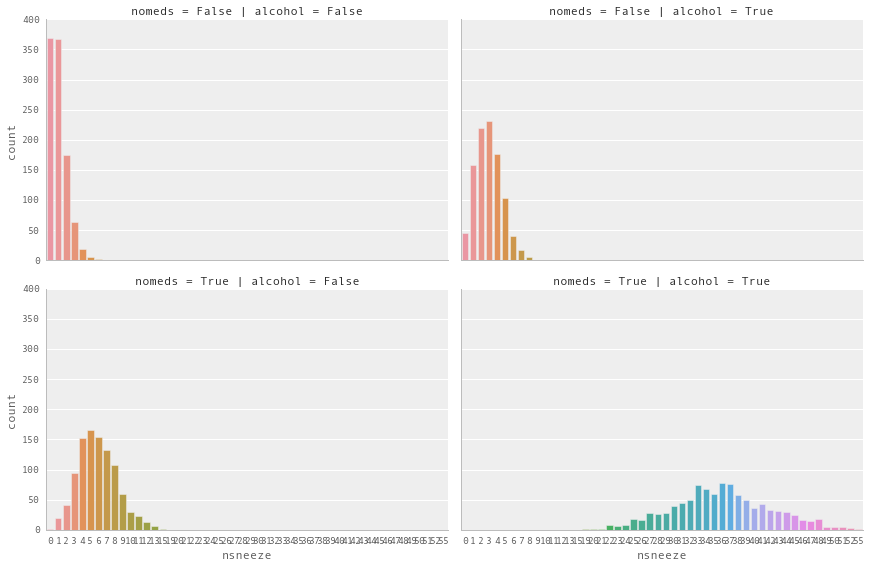

In [8]:
g = sns.factorplot(x='nsneeze', row='nomeds', col='alcohol', data=df,
               kind='count', size=4, aspect=1.5)

**Observe:**

+ This looks a lot like poisson-distributed count data (because it is)
+ With `nomeds == False` and `alcohol == False` (top-left, akak antihistamines WERE used, alcohol was NOT drunk) the mean of the poisson distribution of sneeze counts is low.
+ Changing `alcohol == True` (top-right) increases the sneeze count `nsneeze` slightly
+ Changing `nomeds == True` (lower-left) increases the sneeze count `nsneeze` further
+ Changing both `alcohol == True and nomeds == True` (lower-right) increases the sneeze count `nsneeze` a lot, increasing both the mean and variance.

---

# Poisson Regression

Our model here is a very simple Poisson regression, allowing for interaction of terms:

$$ \theta = exp(\beta X)$$

$$ Y_{sneeze\_count} ~ Poisson(\theta)$$



##### Create linear model for interaction of terms

In [9]:
fml = 'nsneeze ~ alcohol + antihist + alcohol:antihist'  # full patsy formulation

In [10]:
fml = 'nsneeze ~ alcohol * nomeds'  # lazy, alternative patsy formulation

## 1. Manual method, create design matrices and manually specify model

##### Create Design Matrices

In [11]:
(mx_en, mx_ex) = pt.dmatrices(fml, df, return_type='dataframe', NA_action='raise')

In [12]:
pd.concat((mx_ex.head(3),mx_ex.tail(3)))

,Intercept,alcohol[T.True],nomeds[T.True],alcohol[T.True]:nomeds[T.True]
0,1.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0
3997,1.0,1.0,1.0,1.0
3998,1.0,1.0,1.0,1.0
3999,1.0,1.0,1.0,1.0


### Create Model

In [13]:
with pm.Model() as mdl_fish:
    
    # define priors, weakly informative Normal
    b0 = pm.Normal('b0_intercept', mu=0, sd=10)
    b1 = pm.Normal('b1_alcohol[T.True]', mu=0, sd=10)
    b2 = pm.Normal('b2_nomeds[T.True]', mu=0, sd=10)
    b3 = pm.Normal('b3_alcohol[T.True]:nomeds[T.True]', mu=0, sd=10)
    
    # define linear model and exp link function
    theta = (b0 +
            b1 * mx_ex['alcohol[T.True]'] +
            b2 * mx_ex['nomeds[T.True]'] +
            b3 * mx_ex['alcohol[T.True]:nomeds[T.True]']) 

    ## Define Poisson likelihood 
    y = pm.Poisson('y', mu=np.exp(theta), observed=mx_en['nsneeze'].values)
    

### Sample Model

In [14]:
with mdl_fish:
    
    start_MAP = pm.find_MAP(fmin=optimize.fmin_powell)
    trc_fish = pm.sample(2000, start=start_MAP, njobs=2, step=pm.NUTS())

 [-----------------100%-----------------] 2001 of 2000 complete in 34.7 sec

### View Diagnostics

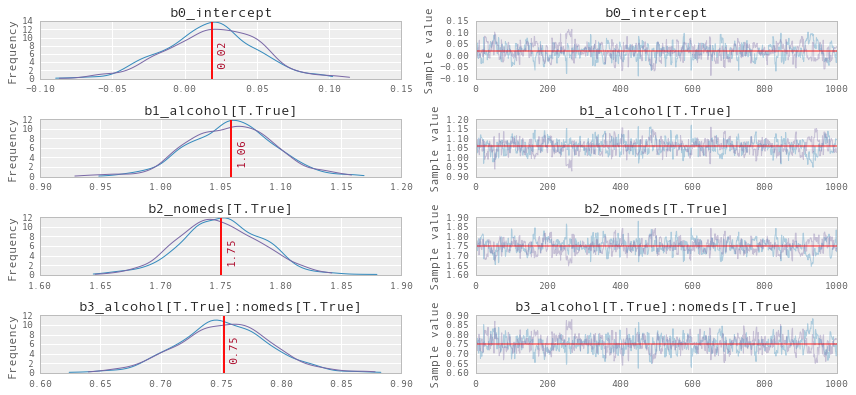

In [15]:
rvs_fish = [rv.name for rv in strip_derived_rvs(mdl_fish.unobserved_RVs)]
plot_traces_pymc(trc_fish[-1000:], varnames=rvs_fish)

**Observe:**

+ The model converges quickly and traceplots looks pretty well mixed

## Transform coeffs and recover theta values

In [16]:
np.exp(pm.df_summary(trc_fish[-1000:], varnames=rvs_fish)[['mean','hpd_2.5','hpd_97.5']])

,mean,hpd_2.5,hpd_97.5
b0_intercept,1.019033,0.957895,1.083158
b1_alcohol[T.True],2.881882,2.687557,3.094581
b2_nomeds[T.True],5.756029,5.408539,6.168330
b3_alcohol[T.True]:nomeds[T.True],2.122779,1.978858,2.295429


**Observe:**

+ The contributions from each feature as a multiplier of the baseline sneezecount appear to be as per the data generation:
    
    
    1. exp(b0_intercept): mean=1.02  cr=[0.96, 1.08]        
    
        Roughly linear baseline count when no alcohol and meds, as per the generated data: 

        theta_noalcohol_meds = 1 (as set above)
        theta_noalcohol_meds = exp(b0_intercept) 
                             = 1


    2. exp(b1_alcohol): mean=2.88  cr=[2.69, 3.09]
    
        non-zero positive effect of adding alcohol, a ~3x multiplier of 
        baseline sneeze count, as per the generated data: 

        theta_alcohol_meds = 3 (as set above)
        theta_alcohol_meds = exp(b0_intercept + b1_alcohol) 
                           = exp(b0_intercept) * exp(b1_alcohol) 
                           = 1 * 3 = 3


    3. exp(b2_nomeds[T.True]): mean=5.76  cr=[5.40, 6.17]    
    
        larger, non-zero positive effect of adding nomeds, a ~6x multiplier of 
        baseline sneeze count, as per the generated data: 

        theta_noalcohol_nomeds = 6 (as set above)
        theta_noalcohol_nomeds = exp(b0_intercept + b2_nomeds)
                               = exp(b0_intercept) * exp(b2_nomeds) 
                               = 1 * 6 = 6
    
    
    4. exp(b3_alcohol[T.True]:nomeds[T.True]): mean=2.12  cr=[1.98, 2.30]
    
        small, positive interaction effect of alcohol and meds, a ~2x multiplier of 
        baseline sneeze count, as per the generated data: 

        theta_alcohol_nomeds = 36 (as set above)
        theta_alcohol_nomeds = exp(b0_intercept + b1_alcohol + b2_nomeds + b3_alcohol:nomeds)
                             = exp(b0_intercept) * exp(b1_alcohol) * exp(b2_nomeds * b3_alcohol:nomeds)
                             = 1 * 3 * 6 * 2 = 36
   


---

## 2. Alternative method, using `pymc.glm`

### Create Model

##### Alternative automatic formulation using `pmyc.glm`

In [17]:
with pm.Model() as mdl_fish_alt:
    
    pm.glm.glm(fml, df, family=pm.glm.families.Poisson())

Applied log-transform to mu and added transformed mu_log to model.


### Sample Model

In [18]:
with mdl_fish_alt:
    
    start_MAP_alt = pm.find_MAP(fmin=optimize.fmin_powell)
    trc_fish_alt = pm.sample(4000, start=start_MAP_alt, njobs=1, step=pm.NUTS())

 [-----------------100%-----------------] 4000 of 4000 complete in 48.4 sec

### View Traces

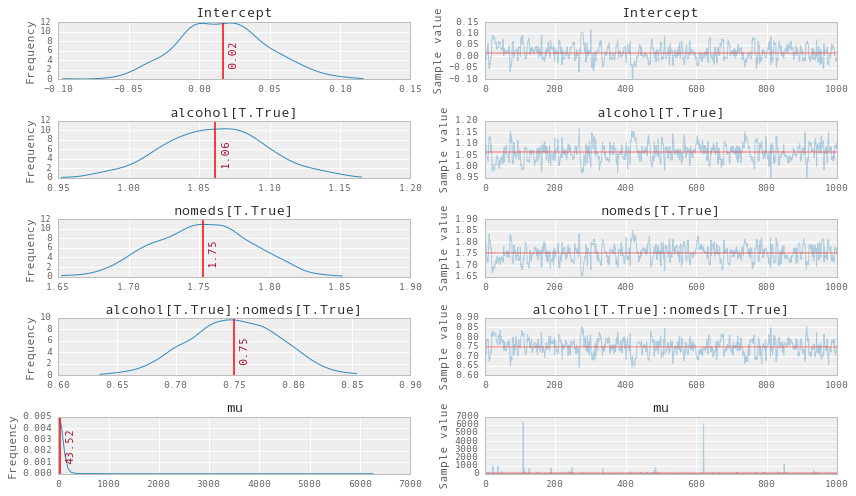

In [19]:
rvs_fish_alt = [rv.name for rv in strip_derived_rvs(mdl_fish_alt.unobserved_RVs)]
plot_traces_pymc(trc_fish_alt[-1000:], varnames=rvs_fish_alt)

### Transform coeffs

In [25]:
np.exp(pm.df_summary(trc_fish_alt[-1000:], varnames=rvs_fish_alt)[['mean','hpd_2.5','hpd_97.5']])

,mean,hpd_2.5,hpd_97.5
Intercept,1.016913e+00,0.958431,1.081468e+00
alcohol[T.True],2.890336e+00,2.689204,3.104546e+00
nomeds[T.True],5.768525e+00,5.427639,6.155485e+00
alcohol[T.True]:nomeds[T.True],2.116617e+00,1.959358,2.264685e+00
mu,7.964644e+18,1.003069,8.049357e+50


**Observe:**

+ The traceplots look well mixed
+ The transformed model coeffs look moreorless the same as those generated by the manual model
+ Note also that the `mu` coeff is for the overall mean of the dataset and has an extreme skew, if we look at the median value ...

In [26]:
np.percentile(trc_fish_alt[-1000:]['mu'], [25,50,75])

array([  4.17219583,   9.44616465,  24.18060789])

... of 9.45 with a range [25%, 75%] of [4.17, 24.18], we see this is pretty close to the overall mean of:

In [27]:
df['nsneeze'].mean()

11.42775

---
Example originally contributed by Jonathan Sedar 2016-05-15 [github.com/jonsedar](https://github.com/jonsedar)